# Hydrogen molecule dissociation via Configuratin Interaction 


This notebook is an extension on the work that has already been done during the lectures on the dissociation curve of $H_2$ using Restricted Hartree-Fock (RHF) and Unrestricted Hartree-Fock (UHF). We use Configuration Interaction (CI) to improve on this. Compared to Hartree-Fock (HF), CI uses a linear combination of Slater Determinants (SD) to compute the energy of the $H_2$ molecule.

$
\begin{equation}
\Phi = \sum_{I=0}c_I \Psi_I = c_0\Psi_0 + c_1\Psi_1 + ...,
\end{equation}
$

where $\Psi_I$ are Slater determinants constructed from a common set of molecular orbitals, and $c_I$ are variational coefficients to be determined.

The reference determinant $\Psi_0$ is usually taken to be the Hartree–Fock ground-state determinant. The remaining determinants $\Psi_I$ correspond to excited configurations obtained by promoting one or more electrons from occupied orbitals to virtual orbitals. These include single excitations, double excitations, and higher-order excitations. Since we work with $H_2$, only 3 terms can be included in the expression for the molecular orbitals, namely $\Psi_0$, $\Psi_i^a$ and $\Psi_{ij}^{ab}$. This means we are able to work with all the terms in the linear combination $\Phi$:

$
\begin{equation}
\Phi = c_0 \Psi_0 + c_1\Psi_i^a + c_2\Psi_{ij}^{ab}
\end{equation}
$

This means that in theory, our expression is exact and we should be able to calculate the exact energy of the $H_2$ molecule (assuming an infinite basis set). However, we will see later that this is too optimistic.

In [1]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from CI_utils_nieuw import solve_rhf, solve_uhf, analyze_equilibrium_orbitals, ao_to_mo_2orb, ci_block_singlet_2orb, compute_ci_energy
from tqdm import tqdm



In [10]:
#Conversion from Bohr to Angstrom for the plotting and comparison with literature
HARTREE_TO_CMINV = 219474.63
VE_EXP = -1.1744746  # Experimental potential minimum (Hartree)
BOHR_TO_ANGSTROM = 0.52917721092

In [ ]:
# Compute integrals for different internuclear distances for the aug-cc-pvdz.gbs basis set
margin = 2.0 
dists = np.geomspace(0.5, 8.0, 40) 
datas = []

for dist in tqdm(dists, desc="Calculating integrals"):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "aug_pvdz.gbs", points
    )
    datas.append(data)

Calculating integrals:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating integrals: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


## HF calculations

In the following cell we compute the $H_2$ energies and orbitals for the RHF case. This is simillar to the exercises, as we reuse the code from there.

We do the same for UHF in the next cell

Solving UHF: 100%|██████████| 40/40 [00:00<00:00, 113.34it/s]


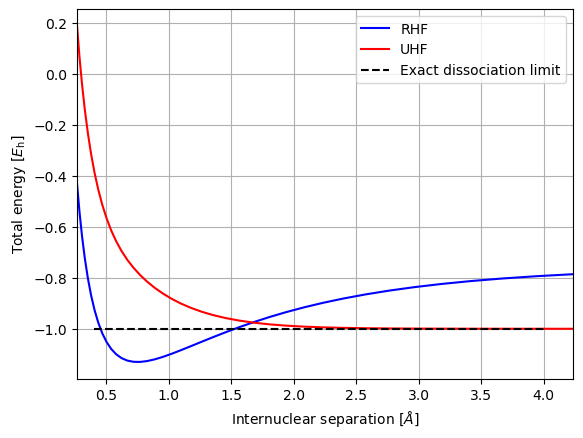

In [3]:
#convert distances from bohr to angstrom
def plot_energy(datas=datas, dists=dists):
    dists_ang = dists * BOHR_TO_ANGSTROM  #distances to angstrom
    plt.close("dissoc")
    _fig, ax = plt.subplots(num="dissoc")
    ax.plot(dists_ang, [data["energy_rhf"] for data in datas], label="RHF", color="blue")
    ax.plot(dists_ang, [data["energy_uhf"] for data in datas], label="UHF", color="red")
    ax.hlines(-1.0, 0.4, 4, color="k", ls="--", label="Exact dissociation limit")
    ax.grid()
    ax.set_xlim(dists_ang[0], dists_ang[-1])
    ax.set_xlabel(r"Internuclear separation [$Å$]")
    ax.set_ylabel(r"Total energy [$E_\mathrm{h}$]")
    ax.legend()

solve_rhf(dists,datas)
solve_uhf(dists,datas)
plot_energy()

The next step is to analyze the densities for RHF and UHF at equilibrium distance. This is the distance where the energy of the system is minimal.

Equilibrium index: 15
psi0 (σg) midpoint value: 0.122250
psi1 (σu) midpoint value: 0.000000


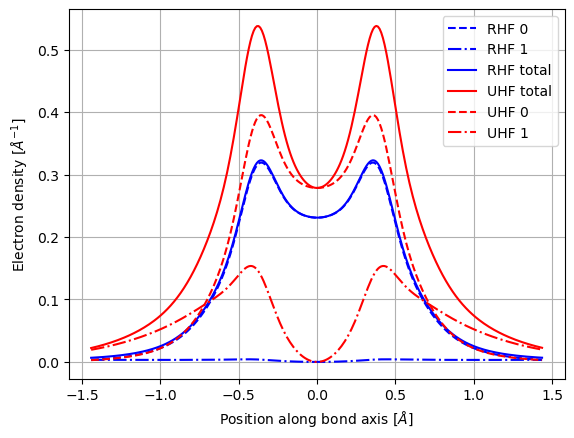

In [4]:
def plot_density():
    plt.close("density")
    fig, ax = plt.subplots(num="density")
    eq_id = analyze_equilibrium_orbitals(datas)["eq_id"]
    data = datas[eq_id]
    zgrid = data["points"][:, 2] * BOHR_TO_ANGSTROM  # to angstrom

    ax.plot(zgrid, data["density0_rhf"] / BOHR_TO_ANGSTROM, "--", label="RHF 0", color="blue")
    ax.plot(zgrid, data["density1_rhf"]/ BOHR_TO_ANGSTROM, "-.", label="RHF 1", color="blue")
    ax.plot(zgrid, data["density_rhf"]/ BOHR_TO_ANGSTROM, label="RHF total", color="blue")
    ax.plot(zgrid, data["density_uhf"]/ BOHR_TO_ANGSTROM, label="UHF total", color="red")
    ax.plot(zgrid, data["density0_uhf"]/ BOHR_TO_ANGSTROM, "--", label="UHF 0", color="red")
    ax.plot(zgrid, data["density1_uhf"]/ BOHR_TO_ANGSTROM, "-.", label="UHF 1", color="red")
    ax.grid()
    ax.set_xlabel(r"Position along bond axis [$Å$]")
    ax.set_ylabel(r"Electron density [$Å^{-1}$]")
    ax.legend()

plot_density()

UHF shows higher peak electron densities than RHF because it removes the artificial "smearing" caused by forcing electrons into shared spatial orbitals. In the RHF method, paired electrons are restricted to the same space, which averages out their distribution and effectively lowers the peak density. UHF breaks this symmetry by allowing $\alpha$ and $\beta$ electrons to occupy different spatial regions, a process known as spin polarization. This flexibility is especially critical at stretched bond geometries, where RHF incorrectly forces electrons to remain delocalized across both nuclei. UHF, by contrast, allows each electron to localize onto a specific atom, resulting in the sharper, higher peaks observed in your plot. Because both methods must integrate to the same total number of electrons, the higher UHF peaks are mathematically balanced by a much narrower, more concentrated distribution. Ultimately, UHF provides a more physically accurate picture of electron localization by treating independent spins separately.

## CI calculations

In the next cells we calculate the $H_2$ energy using the CI method. This will be done in several steps. The first step is to convert the basis consisting of basis functions $b_i$ into a basis consisting of the Molecular orbitals $\sigma_g$ and $\sigma_u$ of the $H_2$ molecule. This facilitates calculations of the Hamiltonian. The Hamiltonian that we want to diagonalize is the next one:

$
\begin{equation}
    \begin{pmatrix}
        \braket{\Psi_0|\mathcal{H}|\Psi_0} & \braket{\Psi_0|\mathcal{H}|\Psi_i^a} & \braket{\Psi_0|\mathcal{H}|\Psi_{ij}^{ab}}\\
        \braket{\Psi_i^a|\mathcal{H}|\Psi_0} & \braket{\Psi_i^a|\mathcal{H}|\Psi_i^a} & \braket{\Psi_i^a|\mathcal{H}|\Psi_{ij}^{ab}}\\
        \braket{\Psi_{ij}^{ab}|\mathcal{H}|\Psi_0} & \braket{\Psi_{ij}^{ab}|\mathcal{H}|\Psi_{i}^{a}} & \braket{\Psi_{ij}^{ab}|\mathcal{H}|\Psi_{ij}^{ab}}\\
    \end{pmatrix}
\end{equation}
$

In [23]:
def ao_to_mo_2orb(data):
    """
    Function to change between the basis consisting of basis functions (b_i) and the basis consisting
    of molecular orbitals (MO). We only keep the 2 MO with lowest energies, corresponding to the two
    sigma orbitals
    ----------
    Parameters
    ----------
    data : dict
        Dictionary containing the data we need (integrals, basis functions, ...)
    ----------
    returns
    ----------
    h, g : np.array(2,2), np.aray(18,18,18,18)
        h is the core Hamiltonian H_kl = T_kl + V_ext_kl
        g is the electron repulsion integral V_ee_ijkl
    """
    C = data["eigvecs_rhf"][:, :2]   # keep 2 lowest MOs (bonding and antibonding MO)

    h_ao = data["hcore"] #core Hamiltonian in atomic orbital basis
    eri_ao = data["eri"] #electronic repulsion integral in atomic orbital basis

    #Transform to molecular orbital basis
    h = C.T @ h_ao @ C
    g = np.einsum("pqrs,pi,qj,rk,sl->ijkl", eri_ao, C, C, C, C, optimize=True)
    
    return h, g

h, g = ao_to_mo_2orb(data)

We only keep the two lowest molecular orbitals to compute the core Hamiltonian and the electron repulsion integrals. This corresponds to the bonding ($\sigma_g$) and antibonding ($\sigma_u$) orbitals, which are the most relevant for describing the electronic structure of the $H_2$ molecule in a minimal basis. This is an approximation we make, making calculations easyer and more efficient. However this also means our theory of full CI is not exact anymore.

Next code will calculate the Hamiltonian shown above, that has to be diagonalized. The Hamiltonian is calculated using the Slater-Condon rules given below. Not that we will never include the exchange term of the electron repulsion integral in the calculations since we are only looking at singlet sates, as stated in the project task.

For a one particle operator $\hat{V}$, we have:

$
\begin{equation}
    \braket{\Psi|\hat{V}|\Psi} = \sum_{i=1}^{N}v_{ii}
\end{equation}
$

$
\begin{equation}
    \braket{\Psi|\hat{V}|\Psi_i^a} = v_{ia}
\end{equation}
$

$
\begin{equation}
    \braket{\Psi|\hat{V}|\Psi_{ij}^{ab}} = 0
\end{equation}
$

And for a two particle operator $\hat{W}$, we have:

$
\begin{equation}
    \braket{\Psi|\hat{W}|\Psi} = \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(w_{ijij}-w_{ijji})
\end{equation}
$

$
\begin{equation}
    \braket{\Psi|\hat{W}|\Psi_i^a} = \sum_{p=1}^{N}(w_{ipap}-w_{ippa})
\end{equation}
$

$
\begin{equation}
    \braket{\Psi|\hat{W}|\Psi_{ij}^{ab}} = w_{ijab}-w_{ijba}
\end{equation}
$

In [39]:
def ci_block_singlet_2orb(h, g, verbose=False):
    """
    Function to calculate the CI Hamiltonian that we diagonalize to get the CI orbitals and energies.
    ----------
    Parameters
    ----------
    h : np.array
        Core Hamiltonian of the system. In our case this has shape (2,2) due to the approximation we make
        of only keeping σg and σu orbitals
    g : npNarray
        Electron repulsion integral for the system. This has shape (2,2,2,2) for the same reason as the
        core Hamiltonian h
    verbose : bool
        True if we want to print text to check if the right terms of the eri are 0
    ----------
    returns
    ----------
    H : np.array
        The CI matrix that we have to diagonalize to find the CI energies for H2
    """

    #One particle operator (core Hamiltonian)
    h00, h11 = h[0,0], h[1,1]
    h01 = h[0,1]

    #Two particle operator (electron repulsion integral)
    g0000 = g[0,0,0,0] #both SD with both electrons in sigma_g (<sigma_g^2|eri|sigma_g^2>)
    g1111 = g[1,1,1,1] #both SD with both electrons in sigma_u (<sigma_u^2|eri|sigma_u^2>)
    g0011 = g[0,0,1,1] #1 SD with 2 electrons in GS, other SD with 2 electrons in excited state
    g0110 = g[0,1,1,0] #both SD with 1 electron in GS and 1 electron in excited state
    g0101 = g[0,1,0,1] #both SD with 1 electron in GS and 1 electron in excited state
    g0001 = g[0,0,0,1] #1 SD with 2 electrons in GS, other SD with 1 electron in excited state
    g0010 = g[0,0,1,0] #1 SD with 2 electrons in GS, other SD with 1 electron in excited state
    g0111 = g[0,1,1,1] #1 SD with 1 electron in GS, other SD with 2 electrons in excited state

    if verbose:
        print(f"h01 = {h01:.6f}, g0001 = {g0001:.6f}, sum = {h01 + g0001:.6f}")
        print(f"(Should be ~0 by Brillouin's theorem for canonical HF orbitals)")

    #diagonal elements of CI hamiltonian
    H = np.zeros((3, 3))
    H[0,0] = 2*h00 + g0000                              #Ground config energy (both electrons in GS), no exchange term
    H[1,1] = h00 + h11 + g0101                          #Singlet single-excitation energy
    H[2,2] = 2*h11 + g1111                              #Doubly-excited config energy (both electrons in excited state) 

    #off-diagonal elements of CI hamiltonian
    H[0,1] = H[1,0] = np. sqrt(2) * (h01 + g0001)       #Coupling between ground and single-excited config
    H[1,2] = H[2,1] = np. sqrt(2) * (h01 + g0111)       #Coupling between single- and doubly-excited config
    H[0,2] = H[2,0] = g0011                             #Coupling between ground and doubly-excited config


    return H

def compute_ci_energy(h, g, dist, data, verbose=True):
    """
    Function that diagonalizes the Hamiltonian computed in ci_block_singlet_2orb to find the
    energies of H2
    ----------
    Parameters
    ----------
    h : np.array
        Core Hamiltonian of the system. In our case this has shape (2,2) due to the approximation we make
        of only keeping σg and σu orbitals
    g : npNarray
        Electron repulsion integral for the system. This has shape (2,2,2,2) for the same reason as the
        core Hamiltonian h
    dist : float
        Value for the internuclear distance
    data : dict 
        Data containing integrals,... for the given internuclear distance
    verbose : bool
        True if we want to print text to check if the right terms of the eri
        are 0 in ci_block_singlet_2orb
    ----------
    returns
    ----------
    dict
        Dictionary containing information such as the Hamiltonian, the CI energies, eigenvectors etc.
    """
    H = ci_block_singlet_2orb(h, g, verbose=verbose)
    eigvals, eigvecs = np.linalg. eigh(H)
    E_elec = eigvals[0]
    E_nuc = 1.0 / dist
    E_tot = E_elec + E_nuc  
    
    # Compare CI reference energy (no correlation) to RHF
    E_ci_ref = H[0,0] + E_nuc  # CI |0,0⟩ state energy
    if verbose:
        print("CI Hamiltonian matrix (Ha):\n", H)
        print(f"H[0,0] + V_nuc (CI ref):    {E_ci_ref:.8f}")
        print(f"RHF total energy:            {data['energy_rhf']:.8f}")
        print(f"Difference (should be ~0):  {E_ci_ref - data['energy_rhf']:.2e}")
        print(f"CI ground-state energy:     {E_tot:.8f}")
    
    return {"H": H, "eigvals": eigvals, "eigvecs": eigvecs, "E_elec": E_elec, "E_tot": E_tot}

Now we have all code needed to perform CI on the results of RHF and UHF. The left two plots will show the dissociation curves for RHF, UHF, CI RHF and CI UHF. The right plot shows the correlation energy, where a part of the correlation enery is recovered using CI. This is due to the introduction of extra slater determinants, absent in HF.

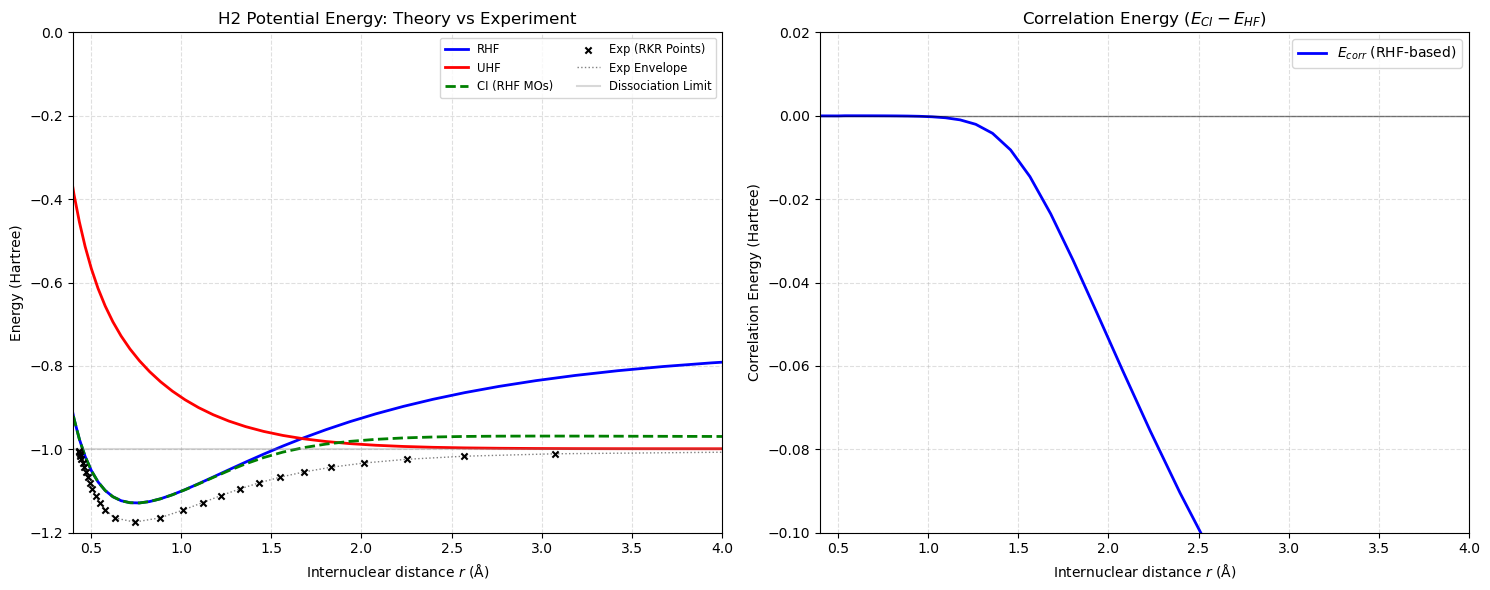

In [15]:
def compute_and_plot_correlation_energy(dists, datas, save_path="correlation_energy_with_exp.png"):
    """
    Compute correlation energy (E_CI - E_HF) for all distances and plot. 
    Returns dict with energy arrays.
    ----------
    Parameters 
    ----------
    dists : list
        Value for the internuclear distance
    datas : list 
        Data containing integrals,... for the given internuclear distance        
    """
    E_rhf, E_uhf, E_ci_rhf = [], [], []
    dists_ang = dists * BOHR_TO_ANGSTROM 

    # 1. Theoretical Calculations
    for dist, data in zip(dists, datas, strict=False):
        E_rhf.append(data["energy_rhf"])
        E_uhf.append(data["energy_uhf"])

        #Core Hamiltonian and electron repulsion integral
        h, g = ao_to_mo_2orb(data)
        results = compute_ci_energy(h, g, dist, data, verbose=False)
        E_ci_rhf.append(results["E_tot"])

    E_rhf, E_uhf = np.array(E_rhf), np.array(E_uhf)
    E_ci_rhf = np.array(E_ci_rhf)

    # Correlation energy = E_CI - E_HF
    E_corr_rhf = E_ci_rhf - E_rhf

    # 2. Experimental RKR Data (Vanderslice et al. 1962)
    # Turning points (Energy cm^-1, r_min A, r_max A)
    rkr_data = [
        (2170.2, 0.632, 0.880), (6331.4, 0.579, 1.011), (10257.6, 0.548, 1.119),
        (13951.3, 0.525, 1.221), (17413.0, 0.507, 1.324), (20641.5, 0.493, 1.432),
        (23633.2, 0.481, 1.549), (26381.7, 0.470, 1.681), (28875.9, 0.461, 1.833),
        (31101.4, 0.453, 2.016), (33040.8, 0.446, 2.250), (34668.5, 0.441, 2.571),
        (35948.3, 0.437, 3.076), (36821.5, 0.435, 4.070), (37213.0, 0.435, 6.000)
    ]
    
    exp_r, exp_e = [0.7414], [VE_EXP] # Start with equilibrium point
    for e_cm, rmin, rmax in rkr_data:
        abs_e = VE_EXP + (e_cm / HARTREE_TO_CMINV)
        exp_r.extend([rmin, rmax])
        exp_e.extend([abs_e, abs_e])
    
    # Sort for the dashed envelope line
    sort_idx = np.argsort(exp_r)
    exp_r_line = np.array(exp_r)[sort_idx]
    exp_e_line = np.array(exp_e)[sort_idx]

    # 3. Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # LEFT PLOT: Total Energies vs Experiment
    axes[0].plot(dists_ang, E_rhf, label="RHF", lw=2, color='blue')
    axes[0].plot(dists_ang, E_uhf, label="UHF", lw=2, color='red')
    axes[0].plot(dists_ang, E_ci_rhf, label="CI (RHF MOs)", lw=2, ls="--", color='green')
    
    # Overlay Experimental points
    axes[0].scatter(exp_r, exp_e, color='black', marker='x', s=20, label="Exp (RKR Points)", zorder=5)
    axes[0].plot(exp_r_line, exp_e_line, color='black', lw=1, ls=':', alpha=0.5, label="Exp Envelope")

    axes[0].axhline(-1.0, color="gray", ls="-", alpha=0.3, label="Dissociation Limit")
    axes[0].set_xlim(0.4, 4.0)
    axes[0].set_ylim(-1.2, -0.85)
    axes[0].set_xlabel("Internuclear distance $r$ (Å)")
    axes[0].set_ylabel("Energy (Hartree)")
    axes[0].set_title("H2 Potential Energy: Theory vs Experiment")
    axes[0].legend(fontsize='small', ncol=2)
    axes[0].grid(True, ls="--", alpha=0.4)
    axes[0].set_ylim(-1.2,0)

    # RIGHT PLOT: Correlation Energy
    axes[1].plot(dists_ang, E_corr_rhf, label="$E_{corr}$ (RHF-based)", lw=2, color="blue")
    axes[1].axhline(0, color="black", lw=1, alpha=0.5)
    axes[1].set_xlim(0.4, 4.0)
    axes[1].set_ylim(-0.1, 0.02)
    axes[1].set_xlabel("Internuclear distance $r$ (Å)")
    axes[1].set_ylabel("Correlation Energy (Hartree)")
    axes[1].set_title("Correlation Energy ($E_{CI} - E_{HF}$)")
    axes[1].legend()
    axes[1].grid(True, ls="--", alpha=0.4)

    plt.tight_layout()
    plt.savefig("Images/correlation_energy.pdf", dpi=200)
    plt.show()

    return {
        "E_rhf": E_rhf, "E_uhf": E_uhf, 
        "E_ci_rhf": E_ci_rhf,
        "exp_r": exp_r_line, "exp_e": exp_e_line
    }

result = compute_and_plot_correlation_energy(dists, datas)

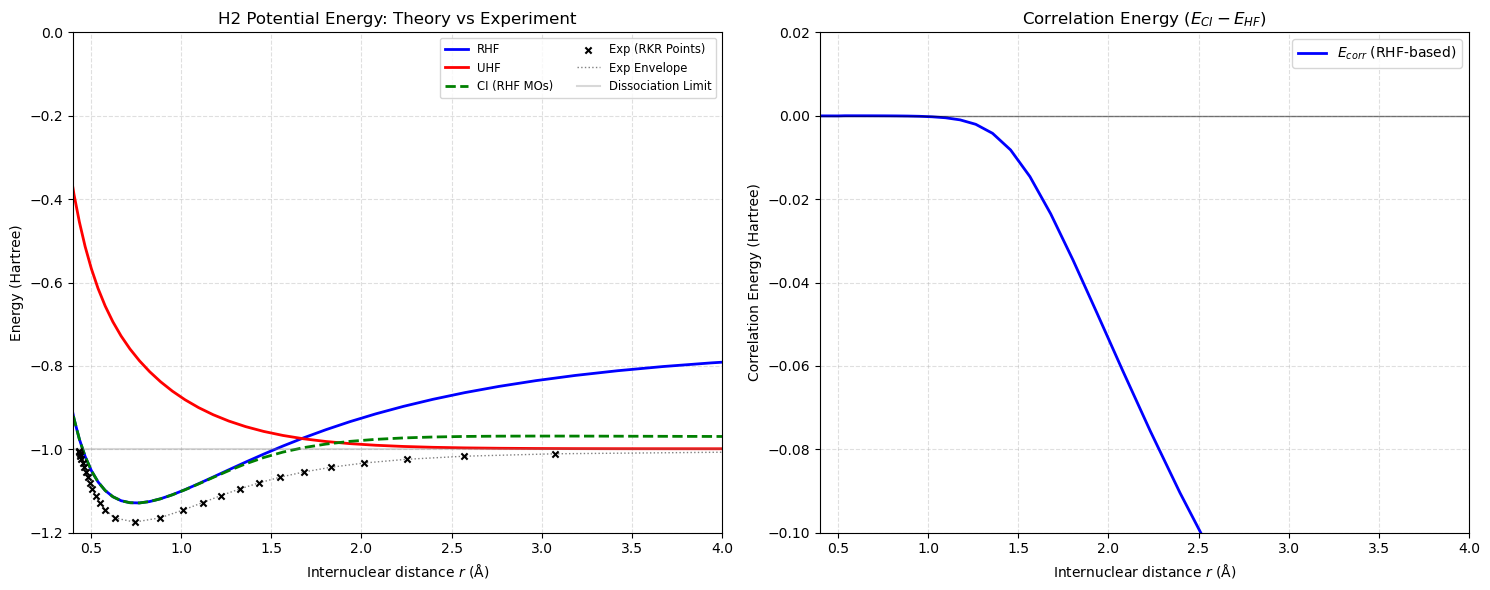

In [16]:
result = compute_and_plot_correlation_energy(dists, datas)

This result is consistent with our expectations. CI clearly improves upon HF by capturing electron correlation. In HF, RHF gives accurate results at short internuclear distances, because both electrons occupy the same molecular orbital and the mean-field approximation is reasonable. UHF, in contrast, performs better at large internuclear distances, because it allows the two electrons to occupy different orbitals, effectively localizing them on separate atoms as $H_2$ dissociates. RHF, however, forces both electrons to remain in the same orbital, which leads to an incorrect dissociation limit. CI corrects this limitation by mixing configurations, reproducing the proper energy curve across all distances.

A next quantity to analyze is the weight of the $\sigma_g$ and $\sigma_u$ orbitals in function of the internuclear distance. This tells us how the electronic wavefunction is distributed among the bonding and antibonding orbitals. At short bond distances, the ground-state wavefunction is dominated by the bonding orbital $\sigma_g$, while the contribution of the antibonding orbital $\sigma_u$ is small. As the bond is stretched, the weight of $\sigma_u$ increases, reflecting the growing importance of the doubly-excited configuration in the CI wavefunction and the onset of static correlation, which allows the correct dissociation into two separate hydrogen atoms.

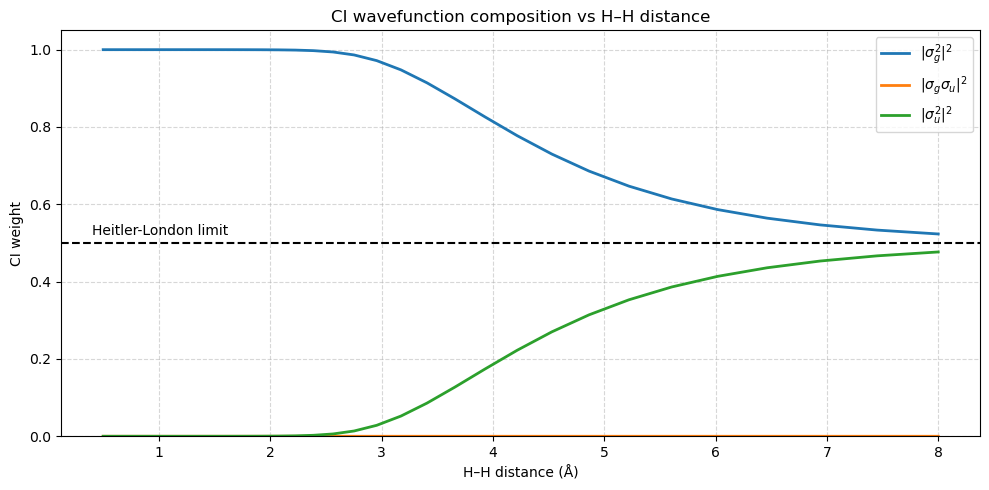

In [17]:
coeff = []
for dist, data in zip(dists, datas, strict=False):
    #Core Hamiltonian and electron repulsion integral
    h, g = ao_to_mo_2orb(data)
    results = compute_ci_energy(h, g, dist, data, verbose=False)
    coeff.append(results["eigvecs"])

coeff = np.array(coeff) #shape (3,3)

#Ground-state CI coefficients
c_g2  = coeff[:, 0, 0]   # |σg²>
c_gu  = coeff[:, 1, 0]   # |σg σu> singlet
c_u2  = coeff[:, 2, 0]   # |σu²>

# Weights
w_g2 = c_g2**2
w_gu = c_gu**2
w_u2 = c_u2**2



plt.figure(figsize=(10,5))

plt.plot(dists, w_g2, label=r"$|\sigma_g^2|^2$", lw=2)
plt.plot(dists, w_gu, label=r"$|\sigma_g\sigma_u|^2$", lw=2)
plt.plot(dists, w_u2, label=r"$|\sigma_u^2|^2$", lw=2)

plt.xlabel("H–H distance (Å)")
plt.ylabel("CI weight")
plt.axhline(0.5, 0,8, ls = '--', color = 'black')
plt.text(0.4, 0.52, "Heitler-London limit", color = "black")
plt.title("CI wavefunction composition vs H–H distance")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ci_weights_vs_R.png", dpi=200)
plt.show()

Next we analyze the equilibrium geometry in more detail.

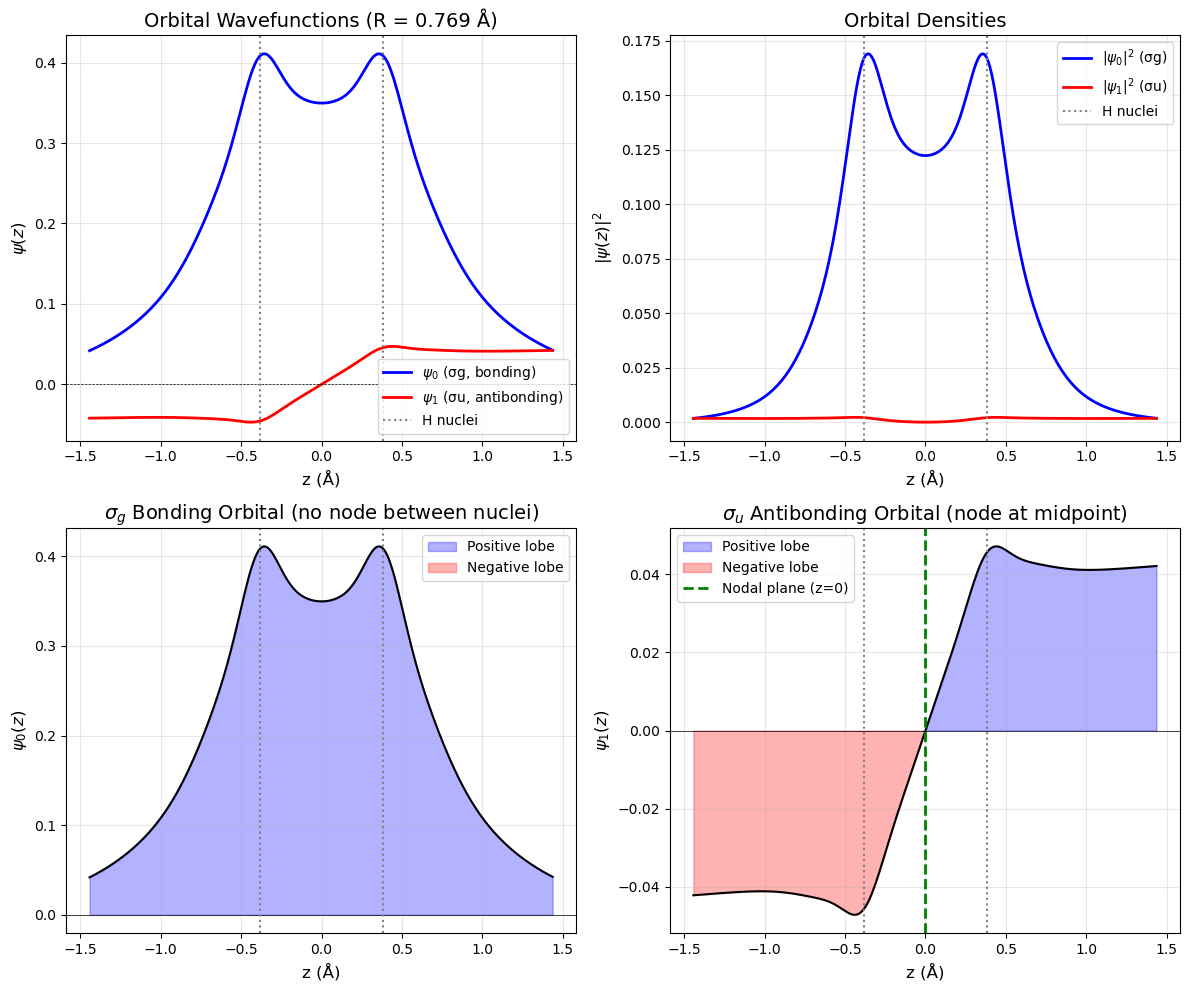


=== Orbital Symmetry Analysis ===
Internuclear distance:  0.7686 Å (1.4524 Bohr)

σg (bonding) orbital:
  - Value at midpoint (z=0): 0.349643
  - Symmetric (same sign on both sides): Yes

σu (antibonding) orbital:
  - Value at midpoint (z=0): -0.000400
  - Has node at midpoint:  Yes


In [18]:
# Choose equilibrium geometry index (minimum energy)
eq_id = int(np.argmin([d["energy_rhf"] for d in datas]))
data = datas[eq_id]
dist = dists[eq_id]

# Get MO coefficients and basis functions
C = data["eigvecs_rhf"]  # AO -> MO coefficients (columns = MOs)
bfs = data["bfs"]        # AO basis functions on grid points

# Convert z-coordinates to Angstroms
z_angstrom = data["points"][:, 2] * BOHR_TO_ANGSTROM
dist_angstrom = dist * BOHR_TO_ANGSTROM

# Build the two lowest spatial MOs on your grid
psi0 = C[:, 0] @ bfs  # σg (bonding orbital)
psi1 = C[:, 1] @ bfs  # σu (antibonding orbital)

# Calculate densities
rho0 = psi0**2
rho1 = psi1**2

def plot_eq_densities():
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Orbital wavefunctions (ψ)
    ax1 = axes[0, 0]
    ax1.plot(z_angstrom, psi0, 'b-', linewidth=2, label=r'$\psi_0$ (σg, bonding)')
    ax1.plot(z_angstrom, psi1, 'r-', linewidth=2, label=r'$\psi_1$ (σu, antibonding)')
    ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax1.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5, label='H nuclei')
    ax1.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax1.set_xlabel(r'z (Å)', fontsize=12)
    ax1.set_ylabel(r'$\psi(z)$', fontsize=12)
    ax1.set_title(f'Orbital Wavefunctions (R = {dist_angstrom:.3f} Å)', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Orbital densities (|ψ|²)
    ax2 = axes[0, 1]
    ax2.plot(z_angstrom, rho0, 'b-', linewidth=2, label=r'$|\psi_0|^2$ (σg)')
    ax2.plot(z_angstrom, rho1, 'r-', linewidth=2, label=r'$|\psi_1|^2$ (σu)')
    ax2.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5, label='H nuclei')
    ax2.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax2.set_xlabel(r'z (Å)', fontsize=12)
    ax2.set_ylabel(r'$|\psi(z)|^2$', fontsize=12)
    ax2.set_title('Orbital Densities', fontsize=14)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Bonding orbital with nodal analysis
    ax3 = axes[1, 0]
    ax3.fill_between(z_angstrom, psi0, 0, where=(psi0 >= 0), 
                    color='blue', alpha=0.3, label='Positive lobe')
    ax3.fill_between(z_angstrom, psi0, 0, where=(psi0 < 0), 
                    color='red', alpha=0.3, label='Negative lobe')
    ax3.plot(z_angstrom, psi0, 'k-', linewidth=1.5)
    ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax3.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax3.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax3.set_xlabel(r'z (Å)', fontsize=12)
    ax3.set_ylabel(r'$\psi_0(z)$', fontsize=12)
    ax3.set_title(r'$\sigma_g$ Bonding Orbital (no node between nuclei)', fontsize=14)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Antibonding orbital with nodal analysis
    ax4 = axes[1, 1]
    ax4.fill_between(z_angstrom, psi1, 0, where=(psi1 >= 0), 
                    color='blue', alpha=0.3, label='Positive lobe')
    ax4.fill_between(z_angstrom, psi1, 0, where=(psi1 < 0), 
                    color='red', alpha=0.3, label='Negative lobe')
    ax4.plot(z_angstrom, psi1, 'k-', linewidth=1.5)
    ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax4.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax4.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
    ax4.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Nodal plane (z=0)')
    ax4.set_xlabel(r'z (Å)', fontsize=12)
    ax4.set_ylabel(r'$\psi_1(z)$', fontsize=12)
    ax4.set_title(r'$\sigma_u$ Antibonding Orbital (node at midpoint)', fontsize=14)
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('h2_orbital_symmetry.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_eq_densities()

# Print analysis
mid_idx = np.argmin(np.abs(data["points"][:, 2]))
print("\n=== Orbital Symmetry Analysis ===")
print(f"Internuclear distance:  {dist_angstrom:.4f} Å ({dist:.4f} Bohr)")
print(f"\nσg (bonding) orbital:")
print(f"  - Value at midpoint (z=0): {psi0[mid_idx]:.6f}")
print(f"  - Symmetric (same sign on both sides): {'Yes' if psi0[mid_idx] > 0.1 else 'No'}")
print(f"\nσu (antibonding) orbital:")
print(f"  - Value at midpoint (z=0): {psi1[mid_idx]:.6f}")
print(f"  - Has node at midpoint:  {'Yes' if abs(psi1[mid_idx]) < 0.01 else 'No'}")